# All metric calculations

In [42]:
import numpy as np
import json
import copy

In [43]:
file = r"C:\\Users\\lucas\\Documents\\Github\\BA_Search_Engine\\backend\\repository\\data\\metrics.json"
with open(file, encoding="utf8") as json_file:
    data = json.load(json_file)

# example data for testing
mlData = list(data.values())[0]['ml']['rating']
ftData = list(data.values())[0]['ft']['rating']

## MAP

In [44]:
def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevanz score < k')
    return np.mean(r)

In [45]:
def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

In [46]:
def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

In [47]:
test1 = [[1, 1, 0, 1, 0], [0, 0, 1, 1, 1]] # BA Beispiel
test2 = [[1, 1, 1, 1, 1], [0, 0, 0, 0, 0]]
test3 = [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]
test4 = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]


print(mean_average_precision(test1))
print(mean_average_precision(test2))
print(mean_average_precision(test3))
print(mean_average_precision(test4))

0.6972222222222222
0.5
1.0
0.0


In [48]:
def add_missing_queries(data, num_queries):
    query_count = num_queries  # TODO: make it a parameter
    # list of all possible query indexes
    num_list = list(range(0, query_count))
    queries_found = list(map(int, data.keys()))  # list of queries found
    # list of queries that have no results
    missing_queries = list(map(str, set(num_list).difference(queries_found)))

    data_cpy = copy.deepcopy(data)
    if len(missing_queries) > 0:
        for q in missing_queries:
            data_cpy[q] = 'n.d.'
    return data_cpy


In [49]:
def calc_map(data, query_count):
    all_data = add_missing_queries(data, query_count)
    all_ratings = []
    for query in all_data:
        rating_arr = all_data[query]
        if rating_arr != 'n.d.':
            sorted_arr = sorted(rating_arr, key=lambda k: k['ranking'])
            query_ratings = []
            for res in sorted_arr:
                query_ratings.append(res['rating'])
            all_ratings.append(query_ratings)
        else:
            all_ratings.append([0])  # query found no results

    return mean_average_precision(all_ratings)

calc_map(mlData, 15)

0.9117658730158731

## TF-IDF

In [50]:
def calc_avg_tfidf(data):
    avg_tfidf = {}
    for query in data:
        rating_arr = data[query]
        score_sum = 0
        for rating in rating_arr:
            score = rating['score']
            score_sum = float(score_sum) + float(score)
        avg_score = round(score_sum/len(rating_arr), 2)
        avg_tfidf[query] = avg_score

    return avg_tfidf

calc_avg_tfidf(mlData)

{'0': 108.55,
 '1': 57.02,
 '2': 115.41,
 '3': 182.69,
 '4': 52.38,
 '5': 56.81,
 '6': 131.26,
 '7': 77.25,
 '8': 103.17,
 '9': 38.77,
 '10': 95.51,
 '11': 90.46,
 '12': 9.53,
 '13': 1.52,
 '14': 0.63}

In [36]:
def calc_highest_tfidf(data):
    highest_arr = {}
    for query in data:
        rating_arr = data[query]
        try:
            sorted_arr = sorted(rating_arr, key=lambda k: int(k['ranking']))
        except TypeError:
            print("ERROR\n")
            print(rating_arr)
        highest_arr[query] = sorted_arr[0]['score']

    return highest_arr

print(calc_highest_tfidf(mlData))

{'0': 125.66686703120256, '1': 60.9176157115223, '2': 120.51203880370471, '3': 184.03505641071075, '4': 54.856486044633215, '5': 80.43183878138937, '6': 140.0842590305578, '7': 87.23094749123473, '8': 103.16964441561274, '9': 38.76666340151514, '10': 110.57444261931437, '11': 106.37164745967448, '12': 9.672177648061053, '13': 1.5164270997047424, '14': 0.6458106637001038}


## nDCG

In [40]:
def cum_gain(relevance):
    return np.asarray(relevance).sum()


def dcg(relevance):
    rel = np.asarray(relevance)
    p = len(rel)

    log2i = np.log2(np.asarray(range(1, p + 1)) + 1)
    return ((np.power(2, rel) - 1) / log2i).sum()



def idcg(relevance):
    rel = np.asarray(relevance).copy()
    rel.sort()
    return dcg(rel[::-1])


def ndcg(relevance, nranks = 10):
    rel = np.asarray(relevance)
    pad = max(0, nranks - len(rel))

    rel = np.pad(rel, (0, pad), 'constant')

    rel = rel[0:min(nranks, len(rel))]

    ideal_dcg = idcg(rel)
    if ideal_dcg == 0:
        return 0.0

    return dcg(rel) / ideal_dcg

In [39]:
def calc_ndcg(data):
    ndcg_score = {}
    for query in data:
        rating_arr = data[query]
        sorted_arr = sorted(rating_arr, key=lambda k: k['ranking'])
        query_ratings = []
        for res in sorted_arr:
            query_ratings.append(res['rating'])
        ndcg_value = ndcg(query_ratings)
        ndcg_score[query] = ndcg_value
    return ndcg_score

calc_ndcg(mlData)

{'0': 0.9911205770005563,
 '1': 1.0,
 '2': 1.0,
 '3': 1.0,
 '4': 1.0,
 '5': 0.9429942892150167,
 '6': 1.0,
 '7': 1.0,
 '8': 1.0,
 '9': 1.0,
 '10': 1.0,
 '11': 0.9530418785472459,
 '12': 1.0,
 '13': 1.0,
 '14': 0.0}

## Precision

In [41]:
def calc_precision(data):
    precision = {}
    for query in data:
        rating_arr = data[query]
        good_count = 0
        for rating in rating_arr:
            if(rating['rating'] == 1):
                good_count = good_count + 1
        precision[query] = (good_count/len(rating_arr))

    return precision
calc_precision(mlData)

{'0': 0.7,
 '1': 1.0,
 '2': 1.0,
 '3': 1.0,
 '4': 1.0,
 '5': 0.8,
 '6': 1.0,
 '7': 1.0,
 '8': 1.0,
 '9': 1.0,
 '10': 1.0,
 '11': 0.7,
 '12': 1.0,
 '13': 1.0,
 '14': 0.0}

# Export metrics from JSON to Excel

In [51]:
import json
import copy

file = r"C:\\Users\\lucas\\Documents\\Github\\BA_Search_Engine\\backend\\repository\\data\\metrics.json"
with open(file, encoding="utf8") as json_file:
    data = json.load(json_file)

In [52]:
def fill_missing_metrics(metrics, query_count):
    for m in metrics:
        if m != 'map':
            # list of all possible query indexes
            num_list = list(range(0, query_count))
            queries_found = list(map(int, metrics[m].keys()))  # list of queries found
            # list of queries that have no results
            missing_queries = list(map(str, set(num_list).difference(queries_found)))

            if len(missing_queries) > 0:
                for q in missing_queries:
                    metrics[m][q] = 'n.d.'
    return metrics

In [53]:
import xlsxwriter

# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook('metrics.xlsx')
worksheet = workbook.add_worksheet()
worksheet.set_column('B:N', 12)

header_format = workbook.add_format({
    'bold': 1,
    'align': 'center',
})

subHeader_format = workbook.add_format({
    'bold': 1,
    'align': 'center',
})

# Start from the first cell. Rows and columns are zero indexed.
row = 0
col = 0

user_count = len(data)
query_count = 15
count = 1
for user in data:
    user_row = count
    worksheet.merge_range(f'B{user_row}:N{user_row}', user, header_format)
    worksheet.merge_range(f'B{user_row+1}:G{user_row+1}', 'ML-Searchengine', subHeader_format)
    worksheet.write(f'B{user_row+2}', 'Avg. TF-IDF')
    worksheet.write(f'C{user_row+2}', 'Top TF-IDF')
    worksheet.write(f'D{user_row+2}', 'nDCG')
    worksheet.write(f'E{user_row+2}', 'Precision')
    worksheet.write(f'F{user_row+2}', 'Index Time')
    worksheet.write(f'G{user_row+2}', 'Request Time')

    worksheet.merge_range(f'I{user_row+1}:N{user_row+1}', 'Fulltext-Searchengine', subHeader_format)
    worksheet.write(f'I{user_row+2}', 'Avg. TF-IDF')
    worksheet.write(f'J{user_row+2}', 'Top TF-IDF')
    worksheet.write(f'K{user_row+2}', 'nDCG')
    worksheet.write(f'L{user_row+2}', 'Precision')
    worksheet.write(f'M{user_row+2}', 'Index Time')
    worksheet.write(f'N{user_row+2}', 'Request Time')

    mlMetrics = fill_missing_metrics(data[user]['ml']['metrics'], query_count)
    ftMetrics = fill_missing_metrics(data[user]['ft']['metrics'], query_count)

    for i in range(query_count):
        worksheet.write(user_row+2+i, 0, f'Query {i+1}')

    m_row = user_row + 2
    m_col = 1
    for metric in mlMetrics:
        if metric != 'map':
            for queryIndex in mlMetrics[metric]:
                try:
                    value =  format(float(mlMetrics[metric][queryIndex]), '.3f')
                    worksheet.write(m_row+int(queryIndex), m_col,  float(value))
                except ValueError:
                    value = 0
                    worksheet.write(m_row+int(queryIndex), m_col,  value)
               
            m_col += 1
            m_row = user_row + 2
    
    m_col = len(mlMetrics) + 1 # anzahl an metriken + 1 weil die erste Spalte für Query Bezeichnung genutzt wird
    for metric in ftMetrics:
        if metric != 'map':
            for queryIndex in ftMetrics[metric]:
                try:
                    value =  format(float(ftMetrics[metric][queryIndex]), '.3f')
                    worksheet.write(m_row+int(queryIndex), m_col, float(value))
                except ValueError:
                    value =  0
                    worksheet.write(m_row+int(queryIndex), m_col, value)
            m_col += 1
            m_row = user_row + 2
        

        
    worksheet.write(query_count + count + 2, 0, 'MAP')
    worksheet.write(query_count + count + 2, 1, format(float(mlMetrics['map']), '.3f'))
    worksheet.write(query_count + count + 2, len(mlMetrics) + 1, format(float(ftMetrics['map']), '.3f'))



    count  = count + query_count + 5 # 5 weil 3 header über den queries + map Zeile + 1 für spacing

workbook.close()

# Plots

In [75]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
import json
import copy

file = r"C:\\Users\\lucas\\Documents\\Github\\BA_Search_Engine\\backend\\repository\\data\\metrics.json"
with open(file, encoding="utf8") as json_file:
    data = json.load(json_file)

In [77]:
plt.rcParams['figure.dpi'] = 100 

## MAP Plot

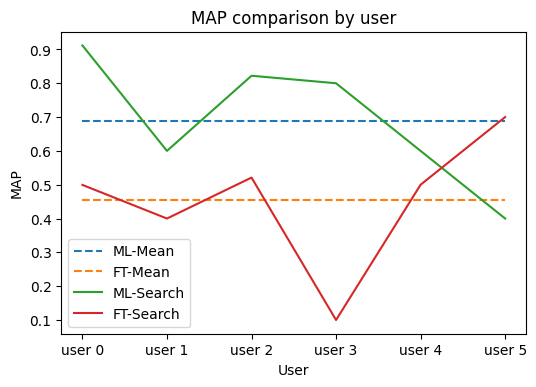

In [79]:
ml_map_metrics = {}
ft_map_metrics = {}

count = 0
for user in data:
    ml_user_metrics = data[user]['ml']['metrics']
    ft_user_metrics = data[user]['ft']['metrics']

    ml_map_metrics[f"user {count}"] = ml_user_metrics['map']
    ft_map_metrics[f"user {count}"] = ft_user_metrics['map']
    count += 1


ml_map_metrics['user 3'] = 0.8
ml_map_metrics['user 4'] = 0.6
ml_map_metrics['user 5'] = 0.4

ft_map_metrics['user 3'] = 0.1
ft_map_metrics['user 4'] = 0.5
ft_map_metrics['user 5'] = 0.7


fig, ax = plt.subplots()

plt.xlabel('User')
plt.ylabel('MAP')
plt.title('MAP comparison by user')

ml_x = list(ml_map_metrics.keys())
ml_y = list(ml_map_metrics.values())

ft_x = list(ft_map_metrics.keys())
ft_y = list(ft_map_metrics.values())

ml_y_mean = [np.mean(ml_y)]*len(ml_x)
ml_mean_line = ax.plot(ml_x, ml_y_mean, label='ML-Mean', linestyle='--')

ft_y_mean = [np.mean(ft_y)]*len(ft_x)
ft_mean_line = ax.plot(ft_x, ft_y_mean, label='FT-Mean', linestyle='--')


ax.plot(ml_map_metrics.keys(), ml_map_metrics.values(), label = "ML-Search")
ax.plot(ft_map_metrics.keys(), ft_map_metrics.values(), label = "FT-Search")
plt.legend()



fig.savefig('plots/map_plot.png', bbox_inches='tight')
        
    

## Precision Plot

{'user 0': {'pos': 0.9230769230769231, 'neg': 0.07692307692307693}, 'user 1': {'pos': 0.06923076923076923, 'neg': 0.9307692307692308}, 'user 2': {'pos': 0.7923076923076923, 'neg': 0.2076923076923077}}
{'user 0': {'pos': 0.95, 'neg': 0.05}, 'user 1': {'pos': 0.06666666666666667, 'neg': 0.9333333333333333}, 'user 2': {'pos': 0.95, 'neg': 0.05}}


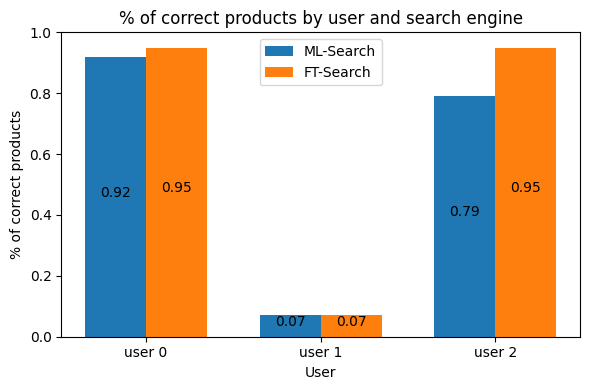

In [80]:
ml_pos_neg  = {}
ft_pos_neg  = {}
count = 0
for user in data:
    ml_user_rating = data[user]['ml']['rating']
    ft_user_rating = data[user]['ft']['rating']

    for query in ml_user_rating:
        for product in ml_user_rating[query]:
            user_num = f"user {count}"
            if user_num not in ml_pos_neg:
                ml_pos_neg[user_num] = {}
            if product['rating'] == 1:
                if 'pos' in ml_pos_neg[user_num]:
                    ml_pos_neg[user_num]['pos'] += 1
                else:
                    ml_pos_neg[user_num]['pos'] = 1
            elif product['rating'] == 0:
                if 'neg' in ml_pos_neg[user_num]:
                    ml_pos_neg[user_num]['neg'] += 1
                else:
                    ml_pos_neg[user_num]['neg'] = 1

    for query in ft_user_rating:
        for product in ft_user_rating[query]:
            user_num = f"user {count}"
            if user_num not in ft_pos_neg:
                ft_pos_neg[user_num] = {}
            if product['rating'] == 1:
                if 'pos' in ft_pos_neg[user_num]:
                    ft_pos_neg[user_num]['pos'] += 1
                else:
                    ft_pos_neg[user_num]['pos'] = 1
            elif product['rating'] == 0:
                if 'neg' in ft_pos_neg[user_num]:
                    ft_pos_neg[user_num]['neg'] += 1
                else:
                    ft_pos_neg[user_num]['neg'] = 1
    count += 1

for user in ml_pos_neg:
    total = ml_pos_neg[user]['pos'] + ml_pos_neg[user]['neg']
    ml_pos_neg[user]['pos'] = ml_pos_neg[user]['pos'] / total
    ml_pos_neg[user]['neg'] = ml_pos_neg[user]['neg'] / total

for user in ft_pos_neg:
    total = ft_pos_neg[user]['pos'] + ft_pos_neg[user]['neg']
    ft_pos_neg[user]['pos'] = ft_pos_neg[user]['pos'] / total
    ft_pos_neg[user]['neg'] = ft_pos_neg[user]['neg'] / total

print(ml_pos_neg)
print(ft_pos_neg)

ml_pos = [round(float(ml_pos_neg[i]['pos']), 2) for i in ml_pos_neg]
# ml_neg = [ml_pos_neg[i]['neg'] for i in ml_pos_neg]
# ml_neg = [ -x for x in ml_neg ]

ft_pos = [round(float(ft_pos_neg[i]['pos']), 2) for i in ft_pos_neg]
# ft_neg = [ft_pos_neg[i]['neg'] for i in ft_pos_neg]
# ft_neg = [ -x for x in ft_neg ]

labels = list(ml_pos_neg.keys())
x = np.arange(len(labels))

width = 0.35

fig, ax = plt.subplots()
rect1 = ax.bar(x - width/2, ml_pos, width, label='ML-Search')
rect2 = ax.bar(x + width/2, ft_pos, width, label='FT-Search')

ax.set_ylabel('% of correct products')
ax.set_xlabel('User')
ax.set_title('% of correct products by user and search engine')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rect1, padding=3, label_type='center', fmt='%g')
ax.bar_label(rect2, padding=3, label_type='center')

plt.ylim((0,1))

fig.tight_layout()
plt.show()

fig.savefig('plots/precision_plot.png', bbox_inches='tight')

In [81]:
def fill_missing(metrics, query_count, fill_with):
    # list of all possible query indexes
    num_list = list(range(0, query_count))
    queries_found = list(map(int, metrics.keys()))  # list of queries found
    # list of queries that have no results
    missing_queries = list(map(str, set(num_list).difference(queries_found)))

    if len(missing_queries) > 0:
        for q in missing_queries:
            metrics[q] = fill_with
    int_dict = {int(k):v for k,v in sorted(metrics.items())}
    return {str(k):v for k,v in sorted(int_dict.items())}


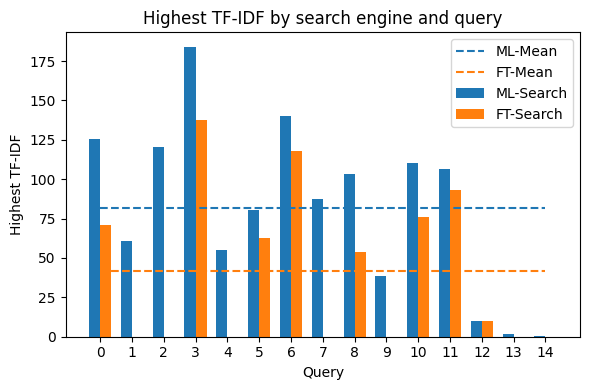

In [82]:
query_count = 15

ml_highest_tfidf = list(data.values())[0]['ml']['metrics']['highest_tfidf']
ft_highest_tfidf = list(data.values())[0]['ft']['metrics']['highest_tfidf']
ml_highest_tfidf = fill_missing(ml_highest_tfidf, query_count, 0)
ft_highest_tfidf = fill_missing(ft_highest_tfidf, query_count, 0)

labels = list(ml_highest_tfidf.keys())
x = np.arange(len(labels))

width = 0.35

fig, ax = plt.subplots()
rect1 = ax.bar(x - width/2, ml_highest_tfidf.values(), width, label='ML-Search')
rect2 = ax.bar(x + width/2, ft_highest_tfidf.values(), width, label='FT-Search')

ml_x = list(ml_highest_tfidf.keys())
ml_y = list(ml_highest_tfidf.values())

ft_x = list(ft_highest_tfidf.keys())
ft_y = list(ft_highest_tfidf.values())

ml_y_mean = [np.mean(ml_y)]*len(ml_x)
ml_mean_line = ax.plot(ml_x, ml_y_mean, label='ML-Mean', linestyle='--')

ft_y_mean = [np.mean(ft_y)]*len(ft_x)
ft_mean_line = ax.plot(ft_x, ft_y_mean, label='FT-Mean', linestyle='--')

ax.set_ylabel('Highest TF-IDF')
ax.set_xlabel('Query')
ax.set_title('Highest TF-IDF by search engine and query')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rect1, padding=3)
# ax.bar_label(rect2, padding=3)

fig.tight_layout()
plt.show()

fig.savefig('plots/top_tf-idf_plot.png', bbox_inches='tight')

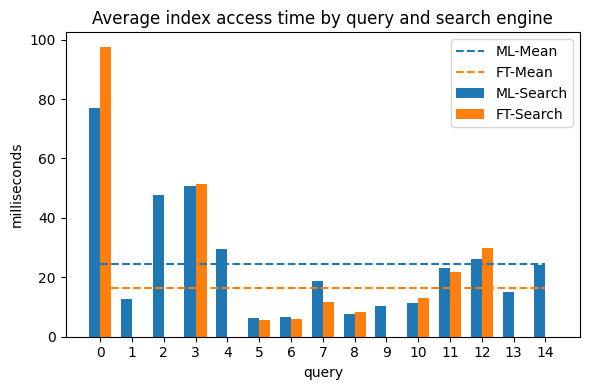

In [83]:
ml_idx_metrics = {}
ft_idx_metrics = {}

query_count = 15

for user in data:
    ml_user_metrics = data[user]['ml']['metrics']
    ft_user_metrics = data[user]['ft']['metrics']
    ml_time = ml_user_metrics['idx_time']
    ft_time = ft_user_metrics['idx_time']
    
    for q in ml_time:
        if q not in ml_idx_metrics:
            ml_idx_metrics[q] = ml_time[q]
        else:
            ml_idx_metrics[q] += ml_time[q]

    for q in ft_time:
        if q not in ft_idx_metrics:
            ft_idx_metrics[q] = ft_time[q]
        else:
            ft_idx_metrics[q] += ft_time[q]

for m in ml_idx_metrics:
    ml_idx_metrics[m] = ml_idx_metrics[m] / len(data)

for m in ft_idx_metrics:
    ft_idx_metrics[m] = ft_idx_metrics[m] / len(data)

ml_idx_metrics = fill_missing(ml_idx_metrics, query_count, 0)
ft_idx_metrics = fill_missing(ft_idx_metrics, query_count, 0)


labels = list(ml_idx_metrics.keys())
x = np.arange(len(labels))

width = 0.35

fig, ax = plt.subplots()
rect1 = ax.bar(x - width/2, ml_idx_metrics.values(), width, label='ML-Search')
rect2 = ax.bar(x + width/2, ft_idx_metrics.values(), width, label='FT-Search')

ml_x = list(ml_idx_metrics.keys())
ml_y = list(ml_idx_metrics.values())

ft_x = list(ft_idx_metrics.keys())
ft_y = list(ft_idx_metrics.values())

ml_y_mean = [np.mean(ml_y)]*len(ml_x)
ml_mean_line = ax.plot(ml_x, ml_y_mean, label='ML-Mean', linestyle='--')

ft_y_mean = [np.mean(ft_y)]*len(ft_x)
ft_mean_line = ax.plot(ft_x, ft_y_mean, label='FT-Mean', linestyle='--')

ax.set_ylabel('milliseconds')
ax.set_xlabel('query')
ax.set_title('Average index access time by query and search engine')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rect1, padding=3)
# ax.bar_label(rect2, padding=3)

fig.tight_layout()
plt.show()
        
fig.savefig('plots/idx_acc_plot.png', bbox_inches='tight')   

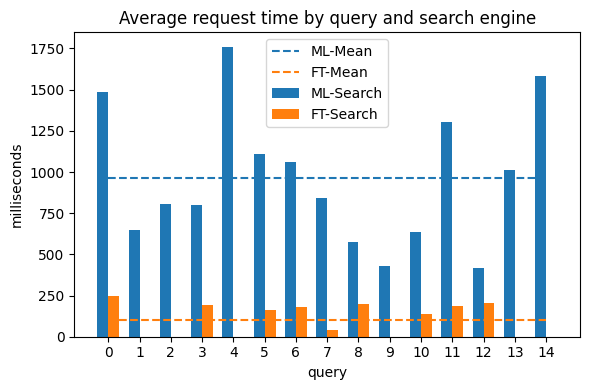

In [84]:
ml_req_metrics = {}
ft_req_metrics = {}

query_count = 15

for user in data:
    ml_user_metrics = data[user]['ml']['metrics']
    ft_user_metrics = data[user]['ft']['metrics']
    ml_time = ml_user_metrics['req_time']
    ft_time = ft_user_metrics['req_time']
    
    for q in ml_time:
        if q not in ml_req_metrics:
            ml_req_metrics[q] = ml_time[q]
        else:
            ml_req_metrics[q] += ml_time[q]

    for q in ft_time:
        if q not in ft_req_metrics:
            ft_req_metrics[q] = ft_time[q]
        else:
            ft_req_metrics[q] += ft_time[q]

for m in ml_req_metrics:
    ml_req_metrics[m] = ml_req_metrics[m] / len(data)

for m in ft_req_metrics:
    ft_req_metrics[m] = ft_req_metrics[m] / len(data)

ml_req_metrics = fill_missing(ml_req_metrics, query_count, 0)
ft_req_metrics = fill_missing(ft_req_metrics, query_count, 0)


labels = list(ml_req_metrics.keys())
x = np.arange(len(labels))

width = 0.35

fig, ax = plt.subplots()
rect1 = ax.bar(x - width/2, ml_req_metrics.values(), width, label='ML-Search')
rect2 = ax.bar(x + width/2, ft_req_metrics.values(), width, label='FT-Search')

ml_x = list(ml_req_metrics.keys())
ml_y = list(ml_req_metrics.values())

ft_x = list(ft_req_metrics.keys())
ft_y = list(ft_req_metrics.values())

ml_y_mean = [np.mean(ml_y)]*len(ml_x)
ml_mean_line = ax.plot(ml_x, ml_y_mean, label='ML-Mean', linestyle='--')

ft_y_mean = [np.mean(ft_y)]*len(ft_x)
ft_mean_line = ax.plot(ft_x, ft_y_mean, label='FT-Mean', linestyle='--')

ax.set_ylabel('milliseconds')
ax.set_xlabel('query')
ax.set_title('Average request time by query and search engine')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rect1, padding=3)
# ax.bar_label(rect2, padding=3)

fig.tight_layout()
plt.show()
        
fig.savefig('plots/req_acc_plot.png', bbox_inches='tight')   